In [ ]:
def bcctcoreClassifier (asyMeasDict, colScarMeasDict):
    
    feat0=asyMeasDict['pLBC']
    
    feat1=asyMeasDict['pBCE']
    
    
    try:
        feat2=colScarMeasDict['cChi2b']
    except Exception:
        print ('NO cChi2b')
        feat2=0
   
    
    features = [feat0, feat1, feat2]
    
    return scorecardPrediction(features)
    
def scorecardPrediction(features) :
    classes = ["UNKNOWN", "EXCELLENT", "GOOD", "FAIR", "POOR"]
    prediction = -1
    points = 0.0
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128

    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727

    if (points < 0.1738):
        prediction = 1
    elif (points<0.3720):
        prediction = 2
    elif (points<0.7002):
        prediction = 3
    else:
        prediction = 4
    return prediction, classes[prediction]


### use RiskSLIM on aesthetic data only with columns chosen by old scorecard

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sbc import SBC



# columns thresholds
pLBC_thresholds = [0.0174, 0.1012, 0.1707]
pBCE_thresholds = [0.0184, 0.3684, 0.9219]
thresholds = {
    'pLBC Value': pLBC_thresholds,
    'pBCE Value': pBCE_thresholds,
    'sbcol1': [0.5],
    'sbcol2': [0.5]
}

# prediction thresholds
prediction_thresholds = [0.1738, 0.3720, 0.7002]


# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# get train and test sets
train_X, test_X, train_y, test_y = train_test_split(aesthetic_evaluation_X, aesthetic_evaluation_y, test_size=0.25, random_state=42)

# do SBC on the train set
sbc = SBC()
sbc_train_X, sbc_train_y = sbc.reduction(train_X, train_y, 4)


# get encoded version of the data with differential coding
def disc_diff_coding(X, thresholds, categorical=[]):
    encoded_X = []
    for col in X.columns:
        if col not in thresholds.keys():
            continue  # skip columns not in thresholds
        if col in categorical:
            bin = pd.Categorical(X[col], categories=thresholds[col]).codes
            num_bins = len(thresholds[col])
        else:
            X_col_float = X[col].astype(float)
            bin = np.digitize(X_col_float, thresholds[col]) # gets bin number of each row
            num_bins = len(thresholds[col]) + 1
        
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bin >= i).astype(int)
        
        encoded_X.append(bin_df)

    # concatenate all encoded columns
    encoded_X = pd.concat(encoded_X, axis=1)

    return encoded_X



# encode the data
encoded_X = disc_diff_coding(sbc_train_X, thresholds)

# add the target variable as the first column, and substitute 0 by -1
encoded_X.insert(0, 'target', sbc_train_y.replace({0: -1}))

# to csv
encoded_X.to_csv('datasets/riskslim/aesthetic_old_scorecard.csv', index=False)

In [25]:
''' 
+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featpLBC Value-bin3                         |          2 points |   + ..... |
| featpLBC Value-bin2                         |          1 points |   + ..... |
| featpBCE Value-bin3                         |          0 points |   + ..... |
| featpBCE Value-bin2                         |          0 points |   + ..... |
| featpBCE Value-bin1                         |          0 points |   + ..... |
| featsbcol2-bin1                             |          0 points |   + ..... |
| featpLBC Value-bin1                         |         -1 points |   + ..... |
| featsbcol1-bin1                             |         -1 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 8                 |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+

 'data_time': 0.0002608299255371094,
 'loss_value': 0.3466639228579918,
 'nodes_processed': 0,
 'objective_value': 0.3466719228579918,
 'optimality_gap': 0.0,
 'run_time': 0.008538961410522461,
 'solution': array([-0.13933046, -1.23123677,  1.55182841,  2.87372761, -0.13350869,
        0.09458333,  0.50473512, -1.98096145, -0.85542722])
'''

" \n+---------------------------------------------+-------------------+-----------+\n| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |\n| =========================================== | ================= | ========= |\n| featpLBC Value-bin3                         |          2 points |   + ..... |\n| featpLBC Value-bin2                         |          1 points |   + ..... |\n| featpBCE Value-bin3                         |          0 points |   + ..... |\n| featpBCE Value-bin2                         |          0 points |   + ..... |\n| featpBCE Value-bin1                         |          0 points |   + ..... |\n| featsbcol2-bin1                             |          0 points |   + ..... |\n| featpLBC Value-bin1                         |         -1 points |   + ..... |\n| featsbcol1-bin1                             |         -1 points |   + ..... |\n| =========================================== | ================= | ========= |\n| ADD POINTS FROM ROWS 1

### ensemble of scorecards --> add column to aesthetic data of total number of points assigned by old scorecard and give that data to my scorecard

In [32]:
def old_scorecard_points(features) :    
    points = 0.0

    # 'pLBC'
    if (features[8]<0.0174):
        points = 0
    elif (features[8]<0.1012):
        points = 0.1538
    elif (features[8]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    # 'pBCE'
    if (features[10]<0.0184):
        points += 0
    elif (features[10]<0.3684):
        points += 0.0636
    elif (features[10]<0.9219):
        points += 0.1938
    else :
        points += 0.2128
    
    return points

testing parameters: {'C': 1000.0, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5737419105573264
testing parameters: {'C': 1000.0, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5982758620689655
testing parameters: {'C': 100.0, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5747223027141891
testing parameters: {'C': 100.0, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.600236646382691
testing parameters: {'C': 10.0, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5757026948710519
testing parameters: {'C': 10.0, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.6022070897324447
testing parameters: {'C': 2.5, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.580623973727422
testing parame

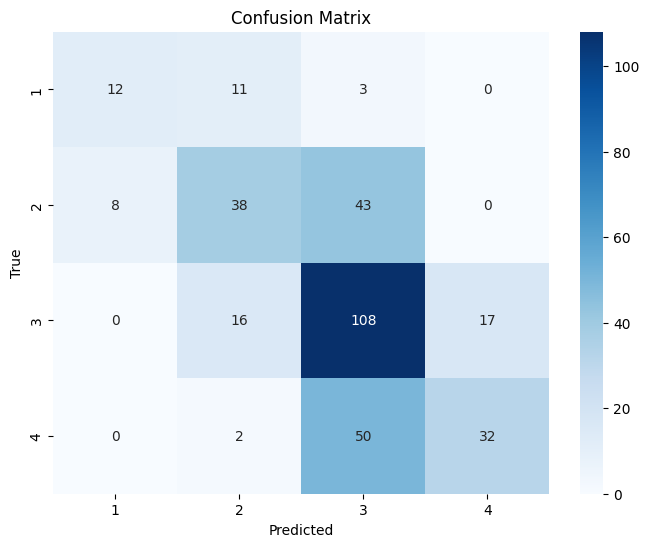

accuracy for class 1: 0.462
accuracy for class 2: 0.427
accuracy for class 3: 0.766
accuracy for class 4: 0.381

Evaluating the model on the train set...
accuracy on train set:  0.6552062868369352
precision on train set:  0.6691521596937459
recall on train set:  0.6552062868369352
f1 score on train set:  0.643245848452293
balanced accuracy on train set:  0.6154910563729106
logistic loss on train set:  0.010347884713928494
mse on train set:  0.3929273084479371

Scorecard table:
                Feature    Weight
0    featBRA Value-bin1  0.000000
1    featBRA Value-bin2  0.245249
2    featBRA Value-bin3  0.000000
3    featBRA Value-bin4  0.053196
4    featBRA Value-bin5  0.000000
35  featpBRA Value-bin1  1.020142
36  featpBRA Value-bin2  0.000000
37  featpBRA Value-bin3 -0.107673
38  featpBRA Value-bin4  0.287051
39  featpBRA Value-bin5  0.000000
                Feature    Weight
5    featLBC Value-bin1  0.228609
6    featLBC Value-bin2  0.000000
7    featLBC Value-bin3  0.062973
8    fea

In [33]:
from scorecard import Scorecard

# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# add column 'points' to X, calculated by old_scorecard_points
for i in range(aesthetic_evaluation_X.shape[0]):
    features = aesthetic_evaluation_X.iloc[i].values
    points = old_scorecard_points(features)
    aesthetic_evaluation_X.loc[i, 'points'] = points
    
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                               thresholds_method='CAIM',
                               encoding_method='1_OUT_OF_K',
                               model_method='ML',
                               params=None,
                               use_sbc=True,
                               K=4,
                               mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}
                               )

scorecard.evaluate()

scorecard.show_scorecard()

testing parameters: {'C': 0.0009765625, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.36346469622331695
testing parameters: {'C': 0.0009765625, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.31435332753791173
testing parameters: {'C': 0.001953125, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.4479522843620206
testing parameters: {'C': 0.001953125, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.3664155317299334
testing parameters: {'C': 0.00390625, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.48729836762291123
testing parameters: {'C': 0.00390625, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5099005119289095
testing parameters: {'C': 0.0078125, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5


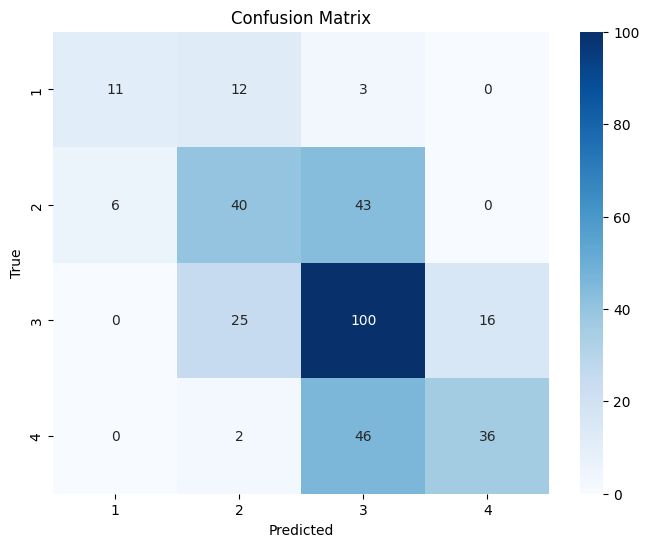

accuracy for class 1: 0.423
accuracy for class 2: 0.449
accuracy for class 3: 0.709
accuracy for class 4: 0.429

Evaluating the model on the train set...
accuracy on train set:  0.6414538310412574
precision on train set:  0.6466542904459451
recall on train set:  0.6414538310412574
f1 score on train set:  0.6324167867536137
balanced accuracy on train set:  0.6082715690532899
logistic loss on train set:  0.010417279161351992
mse on train set:  0.41846758349705304

Scorecard table:
                Feature    Weight
0    featBRA Value-bin1  0.080268
1    featBRA Value-bin2  0.080430
2    featBRA Value-bin3 -0.012401
3    featBRA Value-bin4  0.129751
4    featBRA Value-bin5 -0.278048
35  featpBRA Value-bin1  0.542874
36  featpBRA Value-bin2 -0.150871
37  featpBRA Value-bin3 -0.200336
38  featpBRA Value-bin4  0.086381
39  featpBRA Value-bin5 -0.278048
                Feature    Weight
5    featLBC Value-bin1  0.187247
6    featLBC Value-bin2  0.182007
7    featLBC Value-bin3 -0.103075
8    f

In [34]:
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                                thresholds_method='CAIM',
                                encoding_method='1_OUT_OF_K',
                                model_method='MM',
                                params=None,
                                use_sbc=True,
                                K=4,
                                mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}
                               )

scorecard.evaluate()

scorecard.show_scorecard()

testing parameters: {'C': 1000.0, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5109291992659133
testing parameters: {'C': 1000.0, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5069786535303777
testing parameters: {'C': 100.0, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5050468463247368
testing parameters: {'C': 100.0, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5099681251811069
testing parameters: {'C': 10.0, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5148652564474065
testing parameters: {'C': 10.0, 'class_weight': None}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5099488071090506
testing parameters: {'C': 2.5, 'class_weight': 'balanced'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5138655462184875
testing para

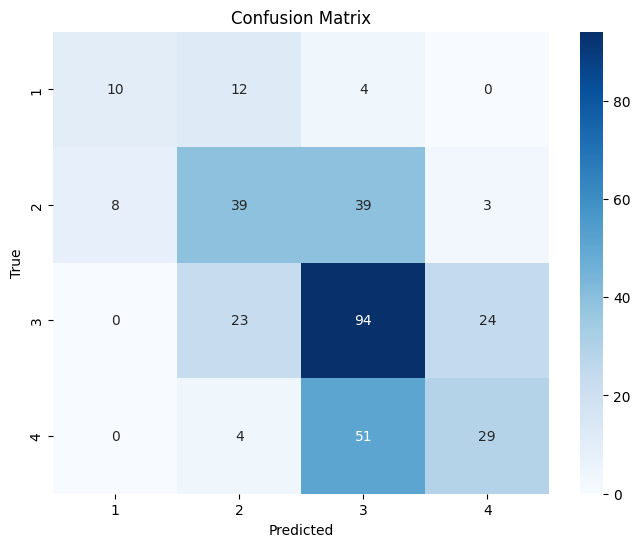

accuracy for class 1: 0.385
accuracy for class 2: 0.438
accuracy for class 3: 0.667
accuracy for class 4: 0.345

Evaluating the model on the train set...
accuracy on train set:  0.9675834970530451
precision on train set:  0.9682723774061874
recall on train set:  0.9675834970530451
f1 score on train set:  0.967510248798533
balanced accuracy on train set:  0.9643607338204341
logistic loss on train set:  0.011583296598119344
mse on train set:  0.03241650294695481

Scorecard table:
                     Feature  Weight
0         featBRA Value-bin1     0.0
1         featBRA Value-bin2     0.0
2         featBRA Value-bin3     0.0
3         featBRA Value-bin4     0.0
4         featBRA Value-bin5     0.0
...                      ...     ...
8131  featpBRA Value-bin1013     0.0
8132  featpBRA Value-bin1014     0.0
8133  featpBRA Value-bin1015     0.0
8134  featpBRA Value-bin1016     0.0
8135  featpBRA Value-bin1017     0.0

[2034 rows x 2 columns]
                     Feature    Weight
1017     

In [36]:
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                                 thresholds_method='INF_BINS',
                                 encoding_method='DIFF_CODING',
                                 model_method='ML',
                                 params=None,
                                 use_sbc=True,
                                 K=4,
                                 mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}
                                )

scorecard.evaluate()

scorecard.show_scorecard()